## Plot d-PDOS of Pt1Au SAA, Pt(ML)/Au and pure Pt

### Load python libraries

In [1]:
import pandas as pd
import numpy as np
from ase.io.trajectory import Trajectory
from ase.visualize import view
import matplotlib.pyplot as plt
from pylab import *
from ase import io
from scipy import integrate
from scipy import interpolate
import waterfall_chart
import random
from scipy.stats import norm
import pickle
from ase.db import connect
import shap

### Plot

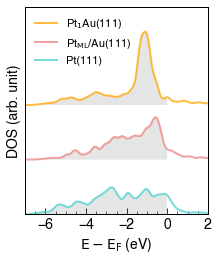

In [4]:
energ = np.linspace(-15,15,3001)
dos_Pt1Au = np.loadtxt('Data/dos_Pt1Au.txt')
dos_PtMLAu = np.loadtxt('Data/dos_PtMLAu.txt')
dos_Pt = np.loadtxt('Data/dos_Pt.txt')

# the id for Pt1Au SAA is 8880


symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 3*1.5*1.67323/2.3,3.5*1.5*1.67323/2.3
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=7*2.0)

fig, ax1 = plt.subplots()

plt.plot(energ,dos_Pt1Au+1.0,color='orange', linewidth = 2,label = r'Pt$_1$Au(111)',alpha=0.75)
plt.plot(energ,dos_PtMLAu+0.5,color='lightcoral', linewidth = 2,label = r'Pt$_{\rm ML}$/Au(111)',alpha=0.75)
plt.plot(energ,dos_Pt,color='mediumturquoise', linewidth = 2,label = 'Pt(111)',alpha=0.75)


plt.xlabel(r'$\rm E - E_F$ (eV)')
plt.ylabel('DOS (arb. unit)')
plt.minorticks_on()
#plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')
plt.legend(ncol=1,loc = 'upper left',frameon=False,prop={'size': 11})
plt.xlim([-7,2])
plt.ylim([0,1.9])
plt.xticks([-6,-4,-2,0,2])
plt.yticks([])

plt.fill_between(energ,0,dos_Pt,where = energ<0,color='gray',alpha=0.2,linewidth=0.0)
plt.fill_between(energ,0.5,dos_PtMLAu+0.5,where = energ<0,color='gray',alpha=0.2,linewidth=0.0)
plt.fill_between(energ,1.0,dos_Pt1Au+1.0,where = energ<0,color='gray',alpha=0.2,linewidth=0.0)

#plt.savefig('Figure2a.png', format='png',transparent = True,dpi=600,bbox_inches='tight')

## Compute Shapley values of all effects contributing to d-band kurtosis change of Pt1Au relative to Pt(ML)/Au

### Load data

In [6]:
reference_data = {'Sc': {'d_cen': 1.7032, 'rd': 0.9409409409409409, 'dij': 3.27, 'Wd': 5.999737383}, 
                  'Ti': {'d_cen': 1.3243, 'rd': 0.7907907907907907, 'dij': 2.91, 'Wd': 6.741977763}, 
                   'V': {'d_cen': 0.5548, 'rd': 0.6906906906906907, 'dij': 2.7, 'Wd': 6.977374918}, 
                  'Cr': {'d_cen': -0.0876, 'rd': 0.6306306306306306, 'dij': 2.56, 'Wd': 7.209708128}, 
                  'Mn': {'d_cen': -0.6036, 'rd': 0.5905905905905906, 'dij': 2.48, 'Wd': 7.084501084}, 
                  'Fe': {'d_cen': -0.9278, 'rd': 0.6206206206206206, 'dij': 2.53, 'Wd': 7.112329237}, 
                  'Co': {'d_cen': -1.5905, 'rd': 0.5605605605605606, 'dij': 2.45, 'Wd': 6.696932181}, 
                  'Ni': {'d_cen': -1.6686, 'rd': 0.5205205205205206, 'dij': 2.49, 'Wd': 5.354092732}, 
                  'Cu': {'d_cen': -2.6521, 'rd': 0.4904904904904905, 'dij': 2.58, 'Wd': 4.244656352}, 
                   'Y': {'d_cen': 2.2707, 'rd': 1.2512512512512513, 'dij': 3.58, 'Wd': 7.873690234}, 
                  'Zr': {'d_cen': 1.6485, 'rd': 1.0710710710710711, 'dij': 3.2, 'Wd': 8.905095875}, 
                  'Nb': {'d_cen': 0.6878, 'rd': 0.9409409409409409, 'dij': 2.98, 'Wd': 8.976212519}, 
                  'Mo': {'d_cen': -0.011, 'rd': 0.8608608608608609, 'dij': 2.84, 'Wd': 9.057322241}, 
                  'Ru': {'d_cen': -1.6305, 'rd': 0.7507507507507507, 'dij': 2.72, 'Wd': 8.066324527}, 
                  'Rh': {'d_cen': -2.0874, 'rd': 0.7207207207207207, 'dij': 2.72, 'Wd': 7.39255913}, 
                  'Pd': {'d_cen': -2.6369, 'rd': 0.7907907907907907, 'dij': 2.79, 'Wd': 5.679312123}, 
                  'Ag': {'d_cen': -3.6577, 'rd': 0.7607607607607607, 'dij': 2.94, 'Wd': 4.503883909}, 
                  'Ta': {'d_cen': 1.1906, 'rd': 1.021021021021021, 'dij': 2.98, 'Wd': 10.89131422}, 
                  'W': {'d_cen': 0.1732, 'rd': 0.9409409409409409, 'dij': 2.86, 'Wd': 10.73729515}, 
                  'Re': {'d_cen': -1.0633, 'rd': 0.8808808808808809, 'dij': 2.75, 'Wd': 10.99527175}, 
                  'Os': {'d_cen': -1.9693, 'rd': 0.8508508508508509, 'dij': 2.72, 'Wd': 10.63999091}, 
                  'Ir': {'d_cen': -2.6636, 'rd': 0.8208208208208209, 'dij': 2.74, 'Wd': 9.50224736}, 
                  'Pt': {'d_cen': -2.6369, 'rd': 0.7907907907907907, 'dij': 2.82, 'Wd': 7.638177581}, 
                  'Au': {'d_cen': -3.6577, 'rd': 0.7607607607607607, 'dij': 2.95, 'Wd': 5.83120117}}

In [ ]:
atoms_ref = io.read('Data/atoms_ref_ML.traj')

X_base = np.array([list(pd.read_csv('Data/shap_test_PtAu.csv')['X_base'])])
X_test = np.array([list(pd.read_csv('Data/shap_test_PtAu.csv')['X_test'])])
site_idx_list = [15, 31, 47, 63, 79, 95, 111, 127, 143, 159, 175, 191, 207, 223, 239, 255, 271, 287, 303, 319, 335, 351, 367, 383, 399, 415, 431, 447, 463, 479]

### Define the function to calculate d-band kurtosis from parameterized Hamiltonian matrix

In [ ]:
def NMM4(X):
    result = np.array([0.0]*len(X))
    for ii in range(len(X)):
        
        HSH = X[ii,302:].reshape(50,50)
        OSH = X[ii,2:302]
        

        all_dij = atoms_ref.get_all_distances()
        nbr_dis = atoms_ref.get_all_distances()[207]
        all_R = atoms_ref.get_positions()[:,None,:] - atoms_ref.get_positions()[None,:,:]
        sort_index = np.argsort(nbr_dis)
        sort_element = np.array(atoms_ref.get_chemical_symbols())[sort_index]
        sort_rd = [reference_data[ele]['rd'] for ele in sort_element]
        
        host_idx_list = []

        for i in range(len(sort_element)):
            if (sort_element[i] == 'Pd') and (sort_index[i] not in site_idx_list):
                host_idx_list.append(i)

        all_dij = X[ii,0]/2.94*all_dij
        nbr_dis = X[ii,0]/2.94*nbr_dis
        all_R = X[ii,0]/2.94*all_R


        for jj in host_idx_list:
            sort_rd[jj] = X[ii,1]


        Natm = 50
        H = np.zeros((Natm*6,Natm*6))

        orb_list = ['dxy','dyz','dxz','dz2','dx2-z2','s']

        for i in range(Natm):
            for j in range(Natm):

                if i != j:
                    rd_1 = sort_rd[i]
                    rd_2 = sort_rd[j]
                    dij = all_dij[sort_index[i]][sort_index[j]]*HSH[i][j]
                    r = all_R[sort_index[i]][sort_index[j]]
                    l, m, n = r/np.linalg.norm(r)

                    if dij <= 3:


                        v_ss_sigma = 7.62*(-1.4)*(1/dij**2)
                        v_sd_sigma = 7.62*(-3.16)*(rd_2**1.5/dij**3.5)
                        v_ds_sigma = 7.62*(-3.16)*(rd_1**1.5/dij**3.5)

                        v_dd_sigma = 7.62*(-16.2)*(rd_1**1.5*rd_2**1.5/dij**5)
                        v_dd_pi = 7.62*(8.75)*(rd_1**1.5*rd_2**1.5/dij**5)
                        v_dd_delta = 0

                        H[6*i+5][6*j+5] = v_ss_sigma

                        H[6*i+5][6*j+1] = 3**0.5*l*m*v_sd_sigma
                        H[6*i+5][6*j+2] = 3**0.5*m*n*v_sd_sigma
                        H[6*i+5][6*j+3] = 3**0.5*l*n*v_sd_sigma
                        H[6*i+5][6*j+4] = (n**2 - (l**2 + m**2)/2)*v_sd_sigma
                        H[6*i+5][6*j+0] = 3**0.5/2*(l**2-m**2)*v_sd_sigma

                        H[6*i+1][6*j+5] = 3**0.5*l*m*v_ds_sigma
                        H[6*i+2][6*j+5] = 3**0.5*m*n*v_ds_sigma
                        H[6*i+3][6*j+5] = 3**0.5*l*n*v_ds_sigma
                        H[6*i+4][6*j+5] = (n**2 - (l**2 + m**2)/2)*v_ds_sigma
                        H[6*i+0][6*j+5] = 3**0.5/2*(l**2-m**2)*v_ds_sigma

                        H[6*i+1][6*j+1] = 3*l**2*m**2*v_dd_sigma + (l**2 + m**2 - 4*l**2*m**2)*v_dd_pi + (n**2 + l**2*m**2)*v_dd_delta
                        H[6*i+1][6*j+2] = H[6*i+2][6*j+1]  = l*n*(3*m**2*v_dd_sigma + (1 - 4*m**2)*v_dd_pi + (m**2 - 1)*v_dd_delta)
                        H[6*i+1][6*j+3] = H[6*i+3][6*j+1] = m*n*(3*l**2*v_dd_sigma + (1 - 4*l**2)*v_dd_pi + (l**2 - 1)*v_dd_delta)
                        H[6*i+1][6*j+4] = H[6*i+4][6*j+1] = 3**0.5*l*m*((n**2 - 0.5*(l**2 + m**2))*v_dd_sigma - 2*n**2*v_dd_pi + 0.5*(1 + n**2)*v_dd_delta)
                        H[6*i+1][6*j+0] = H[6*i+0][6*j+1] = l*m*(l**2 - m**2)*(1.5*v_dd_sigma - 2*v_dd_pi + 0.5*v_dd_delta)

                        H[6*i+2][6*j+2] = 3*n**2*m**2*v_dd_sigma + (n**2 + m**2 - 4*n**2*m**2)*v_dd_pi + (l**2 + n**2*m**2)*v_dd_delta
                        H[6*i+2][6*j+3] = H[6*i+3][6*j+2] = m*l*(3*n**2*v_dd_sigma + (1 - 4*n**2)*v_dd_pi + (n**2 - 1)*v_dd_delta)
                        H[6*i+2][6*j+4] = H[6*i+4][6*j+2] = 3**0.5*m*n*((n**2 - 0.5*(l**2 + m**2))*v_dd_sigma + (l**2 + m**2 - n**2)*v_dd_pi - 0.5*(l**2 + m**2)*v_dd_delta)
                        H[6*i+2][6*j+0] = H[6*i+0][6*j+2] = m*n*(1.5*(l**2 - m**2)*v_dd_sigma - (1 + 2*(l**2 - m**2))*v_dd_pi + (1 + 0.5*(l**2 - m**2))*v_dd_delta)

                        H[6*i+3][6*j+3] = 3*l**2*n**2*v_dd_sigma + (l**2 + n**2 - 4*l**2*n**2)*v_dd_pi + (m**2 + l**2*n**2)*v_dd_delta
                        H[6*i+3][6*j+4] = H[6*i+4][6*j+3] = 3**0.5*l*n*((n**2 - 0.5*(l**2 + m**2))*v_dd_sigma + (l**2 + m**2 - n**2)*v_dd_pi - 0.5*(l**2 + m**2)*v_dd_delta)
                        H[6*i+3][6*j+0] = H[6*i+0][6*j+3] = n*l*(1.5*(l**2 - m**2)*v_dd_sigma + (1 - 2*(l**2 - m**2))*v_dd_pi - (1 - 0.5*(l**2 - m**2))*v_dd_delta)

                        H[6*i+4][6*j+4] = (n**2 - 0.5*(l**2 + m**2))**2*v_dd_sigma + 3*n**2*(l**2 + m**2)*v_dd_pi + 0.75*(l**2 + m**2)**2*v_dd_delta
                        H[6*i+4][6*j+0] = H[6*i+0][6*j+4] = 3**0.5*(l**2 - m**2)*(0.5*(n**2 - 0.5*(l**2 + m**2))*v_dd_sigma - n**2*v_dd_pi + 0.25*(1 + n**2)*v_dd_delta)

                        H[6*i+0][6*j+0] = 0.75*(l**2 - m**2)**2*v_dd_sigma + (l**2 + m**2 - (l**2 - m**2)**2)*v_dd_pi + (n**2 + 0.25*(l**2 - m**2)**2)*v_dd_delta

                if i == j:
                    H[6*i+5][6*j+5] = OSH[6*i+5]
                    H[6*i+1][6*j+1] = OSH[6*i+1]
                    H[6*i+2][6*j+2] = OSH[6*i+2]
                    H[6*i+3][6*j+3] = OSH[6*i+3]
                    H[6*i+4][6*j+4] = OSH[6*i+4]
                    H[6*i+0][6*j+0] = OSH[6*i+0]
        HHHH = H@H@H@H
        HH = H@H
        m4 = 0
        for i in range(5):
            m4 = m4 + HHHH[i][i]

        m2 = 0
        for i in range(5):
            m2 = m2 + HH[i][i]

        norm_m4 = m4/m2**2
        result[ii] = norm_m4
    return result

### Compute Shapley values

In [ ]:
explainer = shap.Explainer(NMM4, X_base)
shap_values_base = explainer(X_base)
shap_values_test = explainer(X_test)

shap_test_dic = {'base':shap_values_base.values[0],'test':shap_values_test.values[0]}
shap_test_df = pd.DataFrame(shap_test_dic)
shap_test_df.to_csv('Data/shap_values_PtAu.csv')

## Compute Shapley value of each effect contributing to d-band kurtosis change of SAAs relative to Pt

### Load data

In [ ]:
TB_param = pickle.load(open('Data/TB_SAA.pkl','rb'))
sort_index_base = TB_param[0][15][:49]

atoms_ref = io.read('Data/atoms_ref_TinNet.traj')

X_base = np.array([list(pd.read_csv('Data/shap_test_12_TinNet_reduce.csv')['X_base'])])
X_test = np.array([list(pd.read_csv('Data/shap_test_12_TinNet_reduce.csv')['X_test_'+str(iii)]) for iii in range(12)])

### Define the function to calculate d-band kurtosis from parameterized Hamiltonian matrix

In [ ]:
def NMM4(X):
    result = np.array([0.0]*len(X))
    for ii in range(len(X)):
        Natm = 49
        HSH = np.ones((Natm,Natm))
        count = 0
        for mm in range(Natm):
            for nn in range(Natm):
                if mm < nn:
                    HSH[mm][nn] = X[ii,296:][count]
                    HSH[nn][mm] = HSH[mm][nn]
                    count += 1
        #HSH = X[ii,296:].reshape(49,49)
        OSH = X[ii,2:296]
        

        all_dij = atoms_ref.get_all_distances()
        nbr_dis = atoms_ref.get_all_distances()[975]
        all_R = atoms_ref.get_positions()[:,None,:] - atoms_ref.get_positions()[None,:,:]
        sort_index = sort_index_base
        sort_element = np.array(atoms_ref.get_chemical_symbols())[sort_index]
        sort_rd = [reference_data[ele]['rd'] for ele in sort_element]
        
        host_idx_list = []

        for i in range(len(sort_element)):
            if sort_element[i] == 'Ag':
                host_idx_list.append(i)

        all_dij = X[ii,0]/2.94*all_dij
        nbr_dis = X[ii,0]/2.94*nbr_dis
        all_R = X[ii,0]/2.94*all_R


        for jj in host_idx_list:
            sort_rd[jj] = X[ii,1]


        Natm = 49
        H = np.zeros((Natm*6,Natm*6))

        orb_list = ['dxy','dyz','dxz','dz2','dx2-z2','s']

        for i in range(Natm):
            for j in range(Natm):

                if i != j:
                    rd_1 = sort_rd[i]
                    rd_2 = sort_rd[j]
                    dij = all_dij[sort_index[i]][sort_index[j]]
                    r = all_R[sort_index[i]][sort_index[j]]
                    l, m, n = r/np.linalg.norm(r)

                    if dij <= 3.6:
                        
                        dij = dij*HSH[i][j]


                        v_ss_sigma = 7.62*(-1.4)*(1/dij**2)
                        v_sd_sigma = 7.62*(-3.16)*(rd_2**1.5/dij**3.5)
                        v_ds_sigma = 7.62*(-3.16)*(rd_1**1.5/dij**3.5)

                        v_dd_sigma = 7.62*(-16.2)*(rd_1**1.5*rd_2**1.5/dij**5)
                        v_dd_pi = 7.62*(8.75)*(rd_1**1.5*rd_2**1.5/dij**5)
                        v_dd_delta = 0

                        H[6*i+5][6*j+5] = v_ss_sigma

                        H[6*i+5][6*j+1] = 3**0.5*l*m*v_sd_sigma
                        H[6*i+5][6*j+2] = 3**0.5*m*n*v_sd_sigma
                        H[6*i+5][6*j+3] = 3**0.5*l*n*v_sd_sigma
                        H[6*i+5][6*j+4] = (n**2 - (l**2 + m**2)/2)*v_sd_sigma
                        H[6*i+5][6*j+0] = 3**0.5/2*(l**2-m**2)*v_sd_sigma

                        H[6*i+1][6*j+5] = 3**0.5*l*m*v_ds_sigma
                        H[6*i+2][6*j+5] = 3**0.5*m*n*v_ds_sigma
                        H[6*i+3][6*j+5] = 3**0.5*l*n*v_ds_sigma
                        H[6*i+4][6*j+5] = (n**2 - (l**2 + m**2)/2)*v_ds_sigma
                        H[6*i+0][6*j+5] = 3**0.5/2*(l**2-m**2)*v_ds_sigma

                        H[6*i+1][6*j+1] = 3*l**2*m**2*v_dd_sigma + (l**2 + m**2 - 4*l**2*m**2)*v_dd_pi + (n**2 + l**2*m**2)*v_dd_delta
                        H[6*i+1][6*j+2] = H[6*i+2][6*j+1]  = l*n*(3*m**2*v_dd_sigma + (1 - 4*m**2)*v_dd_pi + (m**2 - 1)*v_dd_delta)
                        H[6*i+1][6*j+3] = H[6*i+3][6*j+1] = m*n*(3*l**2*v_dd_sigma + (1 - 4*l**2)*v_dd_pi + (l**2 - 1)*v_dd_delta)
                        H[6*i+1][6*j+4] = H[6*i+4][6*j+1] = 3**0.5*l*m*((n**2 - 0.5*(l**2 + m**2))*v_dd_sigma - 2*n**2*v_dd_pi + 0.5*(1 + n**2)*v_dd_delta)
                        H[6*i+1][6*j+0] = H[6*i+0][6*j+1] = l*m*(l**2 - m**2)*(1.5*v_dd_sigma - 2*v_dd_pi + 0.5*v_dd_delta)

                        H[6*i+2][6*j+2] = 3*n**2*m**2*v_dd_sigma + (n**2 + m**2 - 4*n**2*m**2)*v_dd_pi + (l**2 + n**2*m**2)*v_dd_delta
                        H[6*i+2][6*j+3] = H[6*i+3][6*j+2] = m*l*(3*n**2*v_dd_sigma + (1 - 4*n**2)*v_dd_pi + (n**2 - 1)*v_dd_delta)
                        H[6*i+2][6*j+4] = H[6*i+4][6*j+2] = 3**0.5*m*n*((n**2 - 0.5*(l**2 + m**2))*v_dd_sigma + (l**2 + m**2 - n**2)*v_dd_pi - 0.5*(l**2 + m**2)*v_dd_delta)
                        H[6*i+2][6*j+0] = H[6*i+0][6*j+2] = m*n*(1.5*(l**2 - m**2)*v_dd_sigma - (1 + 2*(l**2 - m**2))*v_dd_pi + (1 + 0.5*(l**2 - m**2))*v_dd_delta)

                        H[6*i+3][6*j+3] = 3*l**2*n**2*v_dd_sigma + (l**2 + n**2 - 4*l**2*n**2)*v_dd_pi + (m**2 + l**2*n**2)*v_dd_delta
                        H[6*i+3][6*j+4] = H[6*i+4][6*j+3] = 3**0.5*l*n*((n**2 - 0.5*(l**2 + m**2))*v_dd_sigma + (l**2 + m**2 - n**2)*v_dd_pi - 0.5*(l**2 + m**2)*v_dd_delta)
                        H[6*i+3][6*j+0] = H[6*i+0][6*j+3] = n*l*(1.5*(l**2 - m**2)*v_dd_sigma + (1 - 2*(l**2 - m**2))*v_dd_pi - (1 - 0.5*(l**2 - m**2))*v_dd_delta)

                        H[6*i+4][6*j+4] = (n**2 - 0.5*(l**2 + m**2))**2*v_dd_sigma + 3*n**2*(l**2 + m**2)*v_dd_pi + 0.75*(l**2 + m**2)**2*v_dd_delta
                        H[6*i+4][6*j+0] = H[6*i+0][6*j+4] = 3**0.5*(l**2 - m**2)*(0.5*(n**2 - 0.5*(l**2 + m**2))*v_dd_sigma - n**2*v_dd_pi + 0.25*(1 + n**2)*v_dd_delta)

                        H[6*i+0][6*j+0] = 0.75*(l**2 - m**2)**2*v_dd_sigma + (l**2 + m**2 - (l**2 - m**2)**2)*v_dd_pi + (n**2 + 0.25*(l**2 - m**2)**2)*v_dd_delta

                if i == j:
                    H[6*i+5][6*j+5] = OSH[6*i+0]
                    H[6*i+1][6*j+1] = OSH[6*i+1]
                    H[6*i+2][6*j+2] = OSH[6*i+2]
                    H[6*i+3][6*j+3] = OSH[6*i+3]
                    H[6*i+4][6*j+4] = OSH[6*i+4]
                    H[6*i+0][6*j+0] = OSH[6*i+5]
        HHHH = H@H@H@H
        HH = H@H
        m4 = 0
        for i in range(5):
            m4 = m4 + HHHH[i][i]

        m2 = 0
        for i in range(5):
            m2 = m2 + HH[i][i]

        norm_m4 = m4/m2**2
        result[ii] = norm_m4
    return result

### Compute Shapley values

In [ ]:
explainer = shap.Explainer(NMM4, X_base)
shap_values_base = explainer(X_base,max_evals=1027)
shap_values_test = explainer(X_test,max_evals=1027)

shap_test_dic = {'base':shap_values_base.values[0],'test_0':shap_values_test.values[0],'test_1':shap_values_test.values[1],'test_2':shap_values_test.values[2],'test_3':shap_values_test.values[3],'test_4':shap_values_test.values[4],'test_5':shap_values_test.values[5],'test_6':shap_values_test.values[6],'test_7':shap_values_test.values[7],'test_8':shap_values_test.values[8],'test_9':shap_values_test.values[9],'test_10':shap_values_test.values[10],'test_11':shap_values_test.values[11]}
shap_test_df = pd.DataFrame(shap_test_dic)
shap_test_df.to_csv('shap_values_12_TinNet_M4.csv')

## Visualize the correlation between the physical quantities and Shapley values of orbital resonance and orbital coupling effects contributing to d-band kurtosis change 

### Prepare data

In [7]:
shap_data = pd.read_csv('Data/shap_values_12_TinNet_M4.csv')
sum_d_list = []

for i in range(12):
    shap = list(shap_data['test_'+str(i)])[2:296]
    sum_d = 0
    for j in range(49):
        sum_d += shap[6*j+1]
        sum_d += shap[6*j+2]
        sum_d += shap[6*j+3]
        sum_d += shap[6*j+4]
        sum_d += shap[6*j+5]
    sum_d_list.append(sum_d)

sum_dij_list = []
for i in range(12):
    shap = [list(shap_data['test_'+str(i)])[0]]
    sum_dij = sum(shap)
    sum_dij_list.append(sum_dij)
    
sum_rd_list = []
for i in range(12):
    shap = [list(shap_data['test_'+str(i)])[1]]
    sum_rd = sum(shap)
    sum_rd_list.append(sum_rd)

element_list = ['Ag','Au','Ir','Cu','Pt','Pd','Rh','Os','Ni','Ru','Co','Re']
d_levels = np.array([reference_data[ele]['d_cen'] for ele in element_list])

### Plot for the d-d orbital resonance effect

In [ ]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 1.5*1.5*1.67323,1.5*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=8*2.0)


fig, ax = plt.subplots()

X = d_levels - d_levels[4]
y = sum_d_list

plt.scatter(X,y,s=50,marker='s',color = 'coral')

ax.set_xlabel(r'$d$-level misalignment (eV)')
ax.set_ylabel('Shapley value')

plt.xlim([-5- d_levels[4],-0.5- d_levels[4]])
plt.ylim([-0.2,0.7])

plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

plt.xticks([-2,-1,0,1,2])
plt.yticks([-0.2,0,0.2,0.4,0.6])

Z = np.polyfit(X,y,2)
corr_matrix = np.corrcoef(X, y)
corr = corr_matrix[0,1]
X_fit = np.linspace(X.min(),X.max(),10)

plt.plot(np.sort(X_fit),(Z[0]*X_fit**2+Z[1]*X_fit+Z[2])[np.argsort(X_fit)],'--',color='gray',linewidth=1)

#plt.savefig('Figure2c.png', format='png',transparent = True,dpi=300, bbox_inches='tight')

### Plot for orbital coupling effect

In [ ]:
symbols = ['s','o','^','v','<','>','+','x','D','d'] # Symbol
lps = [k+'-' for k in ['o','^','v','<','>','s','+','x','D','d']] # Line + Symbol
colors= ['b','r','g','c','m','y','k','w'] # Color
ms = 4
ew = 1.5
rcParams['figure.figsize'] = 1.5*1.5*1.67323,1.5*1.5*1.67323
rcParams['ps.useafm'] = True
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['axes.linewidth'] = 1

rcParams['pdf.fonttype'] = 42
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('xtick.minor', size=3)
matplotlib.rc('ytick.major', size=6)
matplotlib.rc('ytick.minor', size=3)
matplotlib.rc('lines', markeredgewidth=0.5*2)
matplotlib.rc('font', size=8*2.0)

fig, ax = plt.subplots()

X = 762*np.array([reference_data[ele]['rd'] for ele in element_list])**1.5/np.array([reference_data[ele]['dij']**5 for ele in element_list])
y = np.array(sum_rd_list) + np.array(sum_dij_list)

plt.scatter(X,y,s=50,marker='s',color = 'brown')

ax.set_xlabel('TB coupling strength (a.u.)')
#ax.set_xlabel(r'$d$-level misalignment (eV)')
ax.set_ylabel('Shapley value')

plt.xlim([1.5,4.5])
plt.ylim([-1.8,3.3])

plt.minorticks_on()
plt.tick_params(axis="y",direction="in",which='both')
plt.tick_params(axis="x",direction="in",which='both')

plt.xticks([])
plt.yticks([-1,0,1,2,3])

Z = np.polyfit(X,y,1)
corr_matrix = np.corrcoef(X, y)
corr = corr_matrix[0,1]
print('R = '+str(corr))
X_fit = np.linspace(X.min(),X.max(),10)

plt.plot(np.sort(X_fit),(Z[0]*X_fit+Z[1])[np.argsort(X_fit)],'--',color='gray',linewidth=1)

#plt.savefig('Figure2d.png', format='png',transparent = True,dpi=600, bbox_inches='tight')